In [868]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

Data Preparation

In [869]:
churn_df = pd.read_csv('../dataset/telco_customer_churn.csv')

In [870]:
churn_df.columns = churn_df.columns.str.lower().str.strip().str.replace(' ', '_')

In [871]:
churn_df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [872]:
churn_df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [873]:
churn_df.totalcharges = pd.to_numeric(churn_df['totalcharges'], errors='coerce')

churn_df.totalcharges = churn_df.totalcharges.fillna(0)

In [874]:
churn_df.churn.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: churn, dtype: object

In [875]:
churn_df.churn = (churn_df.churn == 'Yes').astype(int)

Setting up The Validation Framework

In [876]:
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [877]:
df_full_train, df_test = train_test_split(churn_df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [878]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [879]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

EDA

In [880]:
df_full_train.isna().sum(0)

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [881]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [882]:
full_churn_rate = df_full_train.churn.mean()

round(full_churn_rate, 2)

np.float64(0.27)

In [883]:
numerical_cols = ['tenure', 'monthlycharges', 'totalcharges']

In [884]:
categorical_cols = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
    'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
    'paymentmethod'
]

In [885]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [886]:
churn_df[categorical_cols].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

Feature Importance

In [887]:
df_full_train[df_full_train.partner == 'Yes'].churn.mean() / full_churn_rate

np.float64(0.7594724924338315)

In [888]:
df_full_train[df_full_train.partner == 'No'].churn.mean() / full_churn_rate

np.float64(1.2216593879412643)

In [889]:
full_churn_rate

np.float64(0.26996805111821087)

In [890]:
from IPython.display import display

In [891]:
for c in categorical_cols:
    print(c)
    df_group = df_full_train.groupby(c)['churn'].agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - full_churn_rate
    df_group['risk'] = df_group['mean'] / full_churn_rate
    display(df_group)
    print()

gender


,mean,count,diff,risk
gender,,,,
Female,0.276824,2796,0.006856,1.025396
Male,0.263214,2838,-0.006755,0.974980



seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208



partner


,mean,count,diff,risk
partner,,,,
No,0.329809,2932,0.059841,1.221659
Yes,0.205033,2702,-0.064935,0.759472



dependents


,mean,count,diff,risk
dependents,,,,
No,0.313760,3968,0.043792,1.162212
Yes,0.165666,1666,-0.104302,0.613651



phoneservice


,mean,count,diff,risk
phoneservice,,,,
No,0.241316,547,-0.028652,0.893870
Yes,0.273049,5087,0.003081,1.011412



multiplelines


,mean,count,diff,risk
multiplelines,,,,
No,0.257407,2700,-0.012561,0.953474
No phone service,0.241316,547,-0.028652,0.893870
Yes,0.290742,2387,0.020773,1.076948



internetservice


,mean,count,diff,risk
internetservice,,,,
DSL,0.192347,1934,-0.077621,0.712482
Fiber optic,0.425171,2479,0.155203,1.574895
No,0.077805,1221,-0.192163,0.288201



onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
No,0.420921,2801,0.150953,1.559152
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.153226,1612,-0.116742,0.567570



onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
No,0.404323,2498,0.134355,1.497672
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.217232,1915,-0.052736,0.804660



deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
No,0.395875,2473,0.125907,1.466379
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.230412,1940,-0.039556,0.853480



techsupport


,mean,count,diff,risk
techsupport,,,,
No,0.418914,2781,0.148946,1.551717
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.159926,1632,-0.110042,0.592390



streamingtv


,mean,count,diff,risk
streamingtv,,,,
No,0.342832,2246,0.072864,1.269897
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.302723,2167,0.032755,1.121328



streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
No,0.338906,2213,0.068938,1.255358
No internet service,0.077805,1221,-0.192163,0.288201
Yes,0.307273,2200,0.037305,1.138182



contract


,mean,count,diff,risk
contract,,,,
Month-to-month,0.431701,3104,0.161733,1.599082
One year,0.120573,1186,-0.149395,0.446621
Two year,0.028274,1344,-0.241694,0.104730



paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
No,0.172071,2313,-0.097897,0.637375
Yes,0.338151,3321,0.068183,1.252560



paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
Bank transfer (automatic),0.168171,1219,-0.101797,0.622928
Credit card (automatic),0.164339,1217,-0.105630,0.608733
Electronic check,0.455890,1893,0.185922,1.688682
Mailed check,0.193870,1305,-0.076098,0.718121


Feature Importance

In [892]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

np.float64(0.0983203874041556)

In [893]:
mutual_info_score(df_full_train.churn, df_full_train.gender)

np.float64(0.0001174846211139946)

In [894]:
mutual_info_score(df_full_train.churn, df_full_train.partner)

np.float64(0.009967689095399745)

In [895]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [896]:
mi = df_full_train[categorical_cols].apply(mutual_info_churn_score)

mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

Feature Importance: Correlation

In [897]:
df_full_train[numerical_cols].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [898]:
df_full_train.loc[df_full_train['tenure'] <= 2, 'churn'].mean()

np.float64(0.5953420669577875)

In [899]:
df_full_train.loc[(df_full_train['tenure'] > 2) &(df_full_train['tenure'] <= 12), 'churn'].mean()

np.float64(0.3994413407821229)

In [900]:
df_full_train.loc[df_full_train['tenure'] > 12, 'churn'].mean()

np.float64(0.17634908339788277)

In [901]:
df_full_train.loc[df_full_train['monthlycharges'] <= 20, 'churn'].mean()

np.float64(0.08795411089866156)

In [902]:
df_full_train.loc[(df_full_train['monthlycharges'] > 20) & (df_full_train['monthlycharges'] <= 50), 'churn'].mean()

np.float64(0.18340943683409436)

In [903]:
df_full_train.loc[df_full_train['monthlycharges'] > 50, 'churn'].mean()

np.float64(0.32499341585462205)

In [904]:
x_train = pd.get_dummies(df_train[categorical_cols + numerical_cols], dtype='int')

x_val = pd.get_dummies(df_val[categorical_cols + numerical_cols], dtype='int')

x_test = pd.get_dummies(df_test[categorical_cols + numerical_cols], dtype='int')

Logistic Regression

In [905]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [906]:
z = np.linspace(-5, 5, 51)
z

array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

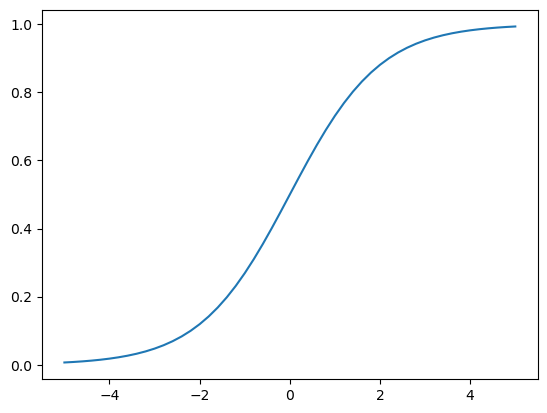

In [907]:
plt.plot(z, sigmoid(z))

In [908]:
def linear_regression(xi, w0, w):

    result = w0

    for j in range(len(w)):
        result = result + xi[j] * w[j]
    
    return result

In [909]:
def logistic_regression(xi, w0, w):

    score = w0

    for j in range(len(w)):
        score = score + xi[j] * w[j]
    
    result = sigmoid(score)
    
    return result

Train Linear Regression

In [910]:
from sklearn.linear_model import LogisticRegression

In [911]:
model = LogisticRegression()

model.fit(x_train, y_train)

d:\Programs\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [912]:
model.coef_[0]

array([ 2.15454207e-01, -7.07304998e-02,  3.62070398e-03,  3.86449409e-04,
       -3.43429708e-02, -7.32883378e-02, -1.65335566e-01,  5.77042570e-02,
       -2.89677008e-02, -7.86636078e-02,  1.40855607e-01, -2.48486916e-01,
       -2.58139652e-01,  1.40855607e-01,  9.65273653e-03, -3.35248710e-01,
        3.16407840e-01, -8.87904388e-02,  2.65769027e-01, -8.87904388e-02,
       -2.84609897e-01,  6.26039163e-02, -8.87904388e-02, -8.14447862e-02,
        6.28139651e-02, -8.87904388e-02, -8.16548349e-02,  2.13864113e-01,
       -8.87904388e-02, -2.32704983e-01, -7.08117791e-02, -8.87904388e-02,
        5.19709093e-02, -1.20194046e-01, -8.87904388e-02,  1.01353176e-01,
        4.73810665e-01, -1.74861454e-01, -4.06580520e-01, -2.31748377e-01,
        1.24117068e-01, -8.70269917e-02, -3.22404601e-02,  7.13352030e-02,
       -5.96990597e-02])

In [913]:
model.coef_[0].round(3)

array([ 0.215, -0.071,  0.004,  0.   , -0.034, -0.073, -0.165,  0.058,
       -0.029, -0.079,  0.141, -0.248, -0.258,  0.141,  0.01 , -0.335,
        0.316, -0.089,  0.266, -0.089, -0.285,  0.063, -0.089, -0.081,
        0.063, -0.089, -0.082,  0.214, -0.089, -0.233, -0.071, -0.089,
        0.052, -0.12 , -0.089,  0.101,  0.474, -0.175, -0.407, -0.232,
        0.124, -0.087, -0.032,  0.071, -0.06 ])

In [914]:
model.predict(x_train)

array([0, 1, 1, ..., 1, 0, 1])

In [915]:
y_pred = model.predict_proba(x_val)[:, 1]

In [916]:
churn_decision = (y_pred >= 0.5)

In [917]:
churn_decision

array([False, False, False, ..., False,  True,  True])

In [918]:
y_val

array([0, 0, 0, ..., 0, 1, 1])

In [919]:
(churn_decision.astype(int) == y_val).mean()

np.float64(0.8034066713981547)

In [920]:
df_pred = pd.DataFrame()

df_pred['probability'] = y_pred

df_pred['prediction'] = churn_decision.astype(int)

df_pred['actual'] = y_val

df_pred['correct'] = df_pred.prediction == df_pred.actual

In [921]:
df_pred

,probability,prediction,actual,correct
0,0.008933,0,0,True
1,0.204298,0,0,True
2,0.212227,0,0,True
3,0.542865,1,1,True
4,0.213872,0,0,True
...,...,...,...,...
1404,0.311672,0,0,True
1405,0.039110,0,1,False
1406,0.135873,0,0,True
1407,0.799325,1,1,True


In [922]:
df_pred['correct'].value_counts()

correct
True     1132
False     277
Name: count, dtype: int64

Model Interpretation

In [923]:
dict(zip(x_train.columns, model.coef_[0].round(3)))

{'seniorcitizen': np.float64(0.215),
 'tenure': np.float64(-0.071),
 'monthlycharges': np.float64(0.004),
 'totalcharges': np.float64(0.0),
 'gender_Female': np.float64(-0.034),
 'gender_Male': np.float64(-0.073),
 'partner_No': np.float64(-0.165),
 'partner_Yes': np.float64(0.058),
 'dependents_No': np.float64(-0.029),
 'dependents_Yes': np.float64(-0.079),
 'phoneservice_No': np.float64(0.141),
 'phoneservice_Yes': np.float64(-0.248),
 'multiplelines_No': np.float64(-0.258),
 'multiplelines_No phone service': np.float64(0.141),
 'multiplelines_Yes': np.float64(0.01),
 'internetservice_DSL': np.float64(-0.335),
 'internetservice_Fiber optic': np.float64(0.316),
 'internetservice_No': np.float64(-0.089),
 'onlinesecurity_No': np.float64(0.266),
 'onlinesecurity_No internet service': np.float64(-0.089),
 'onlinesecurity_Yes': np.float64(-0.285),
 'onlinebackup_No': np.float64(0.063),
 'onlinebackup_No internet service': np.float64(-0.089),
 'onlinebackup_Yes': np.float64(-0.081),
 'devi

In [924]:
small = ['contract', 'tenure', 'monthlycharges']

df_train_small = df_train[small]
df_val_small = df_val[small]

In [925]:
X_train_small = pd.get_dummies(df_train_small)

X_val_small = pd.get_dummies(df_val_small)

In [926]:
model_small = LogisticRegression()

model_small.fit(X_train_small, y_train)

LogisticRegression()

In [927]:
w0 = model_small.intercept_[0]
w0.round(3)

np.float64(-2.478)

In [928]:
w = model_small.coef_[0]
w

array([-0.03619005,  0.02748534,  0.9711394 , -0.02379507, -0.94828863])

In [929]:
dict(zip(X_train_small.columns, w.round(3)))

{'tenure': np.float64(-0.036),
 'monthlycharges': np.float64(0.027),
 'contract_Month-to-month': np.float64(0.971),
 'contract_One year': np.float64(-0.024),
 'contract_Two year': np.float64(-0.948)}

In [930]:
sigmoid(-2.478 + -0.036 * 2 + 0.027 * 50 + 0.971)

np.float64(0.4429988821891786)

Using the Model

In [931]:
X_full_train = pd.get_dummies(df_full_train[categorical_cols + numerical_cols])

y_full_train = df_full_train['churn']

In [932]:
model = LogisticRegression(max_iter=5000).fit(X_full_train, y_full_train)

In [933]:
X_test = pd.get_dummies(df_test[categorical_cols + numerical_cols])

In [934]:
y_pred = model.predict_proba(x_test)[:, 1]

In [938]:
df_pred = pd.DataFrame()

df_pred['proba'] = y_pred
df_pred['prediction'] = (y_pred >= 0.5).astype(int)
df_pred['actual'] = y_test
df_pred['correct'] = df_pred['prediction'] == df_pred['actual']

In [939]:
df_pred

,proba,prediction,actual,correct
0,0.067507,0,0,True
1,0.095159,0,0,True
2,0.334639,0,0,True
3,0.457670,0,1,False
4,0.217258,0,0,True
...,...,...,...,...
1404,0.525052,1,1,True
1405,0.029526,0,0,True
1406,0.005168,0,0,True
1407,0.203544,0,0,True


In [940]:
df_pred.correct.mean()

np.float64(0.8119233498935415)

In [969]:
customer = pd.get_dummies(X_test).iloc[[10], :]

model.predict_proba(customer)[:, 1]

array([0.48032103])

In [970]:
y_test[10]

np.int64(0)